In [37]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector,Operator,SparsePauliOp
from qiskit.primitives import StatevectorSampler,StatevectorEstimator
from scipy.optimize import minimize
import numpy as np

First we show that for any ansatz, we can start from two different computational basis and applying the ansatz still holds the orthogonality.

[ 0.58985003+0.068645j   -0.0096677 -0.06701054j -0.13361037-0.24816546j
 -0.17084454+0.03912878j -0.05395708-0.61451579j -0.17996549+0.03714567j
 -0.31571978-0.12824745j -0.01456969-0.04446475j]


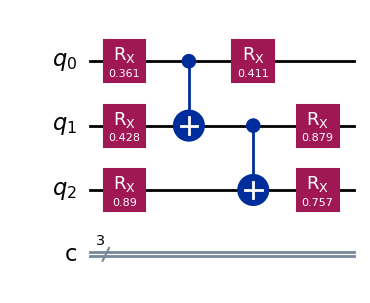

In [29]:
qubits=3
qc_ansatz=TwoLocal(qubits,rotation_blocks="rx",entanglement="linear",entanglement_blocks="cx",reps=1)
qc=QuantumCircuit(qubits,qubits)
qc2=qc.compose(qc_ansatz)
theta=np.random.rand(qc_ansatz.num_parameters)
qc2=qc2.assign_parameters(theta)
z1=Statevector(qc2).data
print(z1)
qc2.decompose().draw("mpl")

Starting from different computational basis by applying x gate in the first qubit.

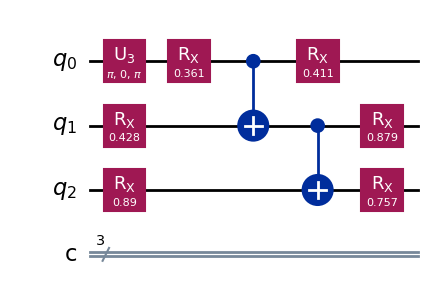

In [30]:
qc3=QuantumCircuit(qubits,qubits)
qc3.x(0)
qc3=qc3.compose(qc_ansatz)
qc3=qc3.assign_parameters(theta)
z2=Statevector(qc3).data
qc3.decompose().draw("mpl")


Now examining the overlap of both the output states

In [35]:
import numpy as np
c=np.dot(np.conj(z1),z2)
print(c)

(6.938893903907228e-18+0j)


Now Lets check the performance for VQE. We find the first eigenstate and store the theta values. Then we check with respect to different computational basis states.

First we generate a hermitian operator over which the VQE will run

In [40]:
def generate_hermitian_matrix(n):
    # Generate a random complex matrix
    A = np.random.rand(n, n) + 1j * np.random.rand(n, n)
    # Construct a Hermitian matrix as (A + A.H) / 2
    H = (A + A.conj().T) / 2
    return H
hermitian_matrix = generate_hermitian_matrix(2**qubits)
print(f"Hermitian Matrix:{hermitian_matrix}")
z=Operator(hermitian_matrix)
Pauli=SparsePauliOp.from_operator(z)
print(Pauli)
qubits=int(np.log2(len(hermitian_matrix)))
print(qubits)

Hermitian Matrix:[[0.35309138+0.j         0.94681864-0.01000421j 0.28814689-0.06880535j
  0.66817257+0.149352j  ]
 [0.94681864+0.01000421j 0.64147754+0.j         0.38653109-0.01998688j
  0.708931  -0.04558747j]
 [0.28814689+0.06880535j 0.38653109+0.01998688j 0.42689184+0.j
  0.58242617+0.05914521j]
 [0.66817257-0.149352j   0.708931  +0.04558747j 0.58242617-0.05914521j
  0.94575786+0.j        ]]
SparsePauliOp(['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ'],
              coeffs=[ 0.59180465+0.j,  0.7646224 +0.j, -0.0245705 +0.j, -0.20181305+0.j,
  0.49853894+0.j,  0.52735183+0.j, -0.08466944+0.j, -0.21039206+0.j,
  0.05719641+0.j, -0.06468256+0.j, -0.14082074+0.j,  0.01160894+0.j,
 -0.0945202 +0.j,  0.18219624+0.j,  0.03457471+0.j,  0.05761997+0.j])
2


Now recall the ansatz we have used previously, but the parameters will be variables and will be optimized through StatevectorEstimator

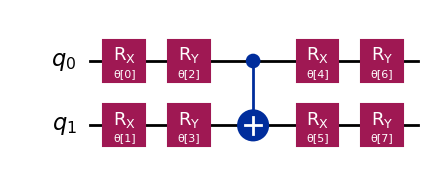

In [52]:
qc_ansatz_vqe=TwoLocal(qubits,rotation_blocks=["rx","ry"],entanglement="linear",entanglement_blocks="cx",reps=1)
qc_vqe=QuantumCircuit(qubits)
qc_vqe=qc_vqe.compose(qc_ansatz_vqe)
theta=np.random.rand(qc_ansatz_vqe.num_parameters)
qc_vqe.decompose().draw("mpl")

Use Statevector Estimator primitve to calculate the energy and design the cost function

In [127]:
estimator=StatevectorEstimator()
def obj_fun(params,qc_fun,ham,estimator_pri):
    job=estimator_pri.run([(qc_fun,ham,[params])]).result()[0]
    return job.data.evs
z=minimize(obj_fun,theta,args=(qc_vqe,Pauli,estimator),method="BFGS")
print(f"Predicted VQE: {z['fun']}")
a=np.linalg.eig(hermitian_matrix)
print(f"True Value:{np.sort(np.real(a[0]))}")
#print(z)

Predicted VQE: -0.5008334788587936
True Value:[-0.50083348  0.05023296  0.33886266  2.47895648]


Now check for the obtained theta values with other computational basis states


True eigenvalues Value:[-0.50083348  0.05023296  0.33886266  2.47895648]
[-0.50083348]
[0.10238286]


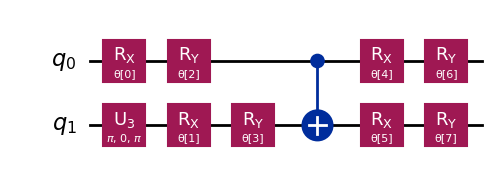

In [128]:
theta_opt=z["x"]
#print(theta_opt)
print(f"True eigenvalues Value:{np.sort(np.real(a[0]))}")
print(obj_fun(theta_opt,qc_vqe,Pauli,estimator))
qc_vqe_o1=QuantumCircuit(qubits)
qc_vqe_o1.x(1)
#qc_vqe_o1.x(0)
new_ansatz=TwoLocal(qubits,rotation_blocks=["rx","ry"],entanglement="linear",entanglement_blocks="cx",reps=1)
qc_vqe_o1=qc_vqe_o1.compose(new_ansatz)
print(obj_fun(theta_opt,qc_vqe_o1,Pauli,estimator))
qc_vqe_o1.decompose().draw("mpl")

In [129]:
Z1=Statevector(qc_vqe_o1.assign_parameters(theta_opt)).data
print(Z1)
#print(a)
Z2=Statevector(qc_vqe.assign_parameters(theta_opt)).data
print(Z2)
print(np.dot(np.conj(Z1),Z2))




[ 0.13221723-0.06865338j -0.2034833 +0.01505181j -0.09892024+0.74143663j
  0.09083273-0.60696724j]
[ 0.14659855+0.73597403j -0.03422472-0.60979756j  0.13474689+0.05409825j
 -0.2026067 -0.04115665j]
(-1.9081958235744878e-17+0j)


In [131]:
# Compute the eigenvalues and eigenvectors of the Hermitian matrix
eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)

# Compute the projection of Z2 onto each eigenvector
projections = np.dot(eigenvectors.T.conj(), Z2)

# Compute the distances
distances = [np.linalg.norm(Z2 - proj * eigvec) for proj, eigvec in zip(projections, eigenvectors.T)]

# Find the minimum distance
min_distance = min(distances)
nearest_index = distances.index(min_distance)

# Print the results
print("Distances from each eigenvector:", distances)
print(f"Minimum distance: {min_distance}")
print(f"Closest eigenvector corresponds to eigenvalue: {eigenvalues[nearest_index]}")


Distances from each eigenvector: [np.float64(2.667259956665657e-06), np.float64(0.9999999999990105), np.float64(0.9999999999976613), np.float64(0.9999999999997705)]
Minimum distance: 2.667259956665657e-06
Closest eigenvector corresponds to eigenvalue: -0.5008334788651785


In [132]:
# Find an orthogonal vector to Z2 using Gram-Schmidt
random_vector = np.random.rand(*Z2.shape) + 1j * np.random.rand(*Z2.shape)  # Random complex vector
orthogonal_vector = random_vector - np.dot(np.conjugate(Z2), random_vector) * Z2
orthogonal_vector = orthogonal_vector / np.linalg.norm(orthogonal_vector)  # Normalize

print("Z2:", Z2)
print("Orthogonal vector to Z2:", orthogonal_vector)

# Compute eigenvalues and eigenvectors of the Hermitian matrix
eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)

# Compute projections for Z2
projections_Z2 = np.dot(eigenvectors.T.conj(), Z2)
distances_Z2 = [np.linalg.norm(Z2 - proj * eigvec) for proj, eigvec in zip(projections_Z2, eigenvectors.T)]

# Compute projections for the orthogonal vector
projections_orthogonal = np.dot(eigenvectors.T.conj(), orthogonal_vector)
distances_orthogonal = [np.linalg.norm(orthogonal_vector - proj * eigvec) for proj, eigvec in zip(projections_orthogonal, eigenvectors.T)]

# Find the minimum distance for each vector
min_distance_Z2 = min(distances_Z2)
nearest_index_Z2 = distances_Z2.index(min_distance_Z2)

min_distance_orthogonal = min(distances_orthogonal)
nearest_index_orthogonal = distances_orthogonal.index(min_distance_orthogonal)

# Print results
print("\n--- Z2 Analysis ---")
print("Distances from each eigenvector (Z2):", distances_Z2)
print(f"Minimum distance (Z2): {min_distance_Z2}")
print(f"Closest eigenvector (Z2) corresponds to eigenvalue: {eigenvalues[nearest_index_Z2]}")

print("\n--- Orthogonal Vector Analysis ---")
print("Distances from each eigenvector (Orthogonal Vector):", distances_orthogonal)
print(f"Minimum distance (Orthogonal Vector): {min_distance_orthogonal}")
print(f"Closest eigenvector (Orthogonal Vector) corresponds to eigenvalue: {eigenvalues[nearest_index_orthogonal]}")


Z2: [ 0.14659855+0.73597403j -0.03422472-0.60979756j  0.13474689+0.05409825j
 -0.2026067 -0.04115665j]
Orthogonal vector to Z2: [0.41649255+0.36214772j 0.45297041+0.34568785j 0.02294904+0.18700412j
 0.50910249+0.27571389j]

--- Z2 Analysis ---
Distances from each eigenvector (Z2): [np.float64(2.667259956665657e-06), np.float64(0.9999999999990105), np.float64(0.9999999999976613), np.float64(0.9999999999997705)]
Minimum distance (Z2): 2.667259956665657e-06
Closest eigenvector (Z2) corresponds to eigenvalue: -0.5008334788651785

--- Orthogonal Vector Analysis ---
Distances from each eigenvector (Orthogonal Vector): [np.float64(0.9999999999991855), np.float64(0.985501739170731), np.float64(0.98285906253931), np.float64(0.25054816957511883)]
Minimum distance (Orthogonal Vector): 0.25054816957511883
Closest eigenvector (Orthogonal Vector) corresponds to eigenvalue: 2.478956478302395
